# Exemples cours sensibilisation explicabilité machine learning
ce notebook permet d'illustrer le cours avec des exemples. 
Dans ce cadre, les données et le modèle sont travaillés très rapidement.
<br />

Les data source proviennent de [Kaggle](https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908)






In [1]:
#Import des librairies
import pandas as pd
import numpy as np

import shap

from datetime import datetime

from category_encoders import OrdinalEncoder

from shapash.explainer.smart_explainer import SmartExplainer

from sklearn.model_selection import train_test_split
import catboost
import lightgbm
from category_encoders import OrdinalEncoder
from sklearn.inspection import PartialDependenceDisplay





In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

## Import du dataset

In [3]:
df = pd.read_csv("../../data/Airplane_Crashes_and_Fatalities_Since_1908.csv")

## Création de variables et feature engineering

In [4]:
#Variable temps
df['Time'] = df['Time'].replace(np.nan, '00:00') 
df['Time'] = df['Time'].str.replace('c: ', '')
df['Time'] = df['Time'].str.replace('c:', '')
df['Time'] = df['Time'].str.replace('c', '')
df['Time'] = df['Time'].str.replace('12\'20', '12:20')
df['Time'] = df['Time'].str.replace('18.40', '18:40')
df['Time'] = df['Time'].str.replace('0943', '09:43')
df['Time'] = df['Time'].str.replace('22\'08', '22:08')
df['Time'] = df['Time'].str.replace('114:20', '00:00')

df['date_time'] = df['Date'] + ' ' + df['Time']
def todate(x):
    return datetime.strptime(x, '%m/%d/%Y %H:%M')
df['date_time'] = df['date_time'].apply(todate) 

/tmp/ipykernel_6329/3039592624.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.



In [5]:
#variables jour, mois année
df['day'] = df['date_time'].dt.weekday
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

In [6]:
#variable Pays
s = df['Location'].str[0:].str.split(',', expand=True)
df['Country'] = s[3].fillna(s[2]).fillna(s[1]).str.strip()

In [7]:
print(df.shape)
df.dropna(subset=['Summary'],inplace=True)
print(df.shape)

(5268, 18)
(4878, 18)


In [8]:
# variable sur les causes du crash
weather_cause = ["weather","fog", "mist", "weat","weather conditions","haze", "visibility", "wind", "winds", "thunderstorm", "storm", "rain",
                 "snow", "ice", "icing", "lightning.", "lightning", "turbulence", "wind shear", "gusty winds"]

pilot_cause = ["pilot error", "crashed", "pilot's error",  "vfr","VFR", "pilot mistake", "pilot's mistake", "pilot fatigue",
               "pilot negligence","Midair collisioin","crew","Failed to gain altitude","attempting to land", "crew error", "crew's error", "crew mistake", "crew's mistake", "crew fatigue", "crew negligence"]

mech_cause = ["engine failure", "equipment failure", "engine malfunction", "equipment malfunction", "mechanical failure",
              "mechanical", "malfunction", "component", "landing gear", "flight control", "mechanical", "malfunction",
              "landing gear", "propeller failure", "power loss", "engine problems", "engine trouble", "engine issues",
              "engine defect", "engine failed","engine broke", "engine shutdown", "engine burst", "engine exploded", "fire", "flames",
              "burned", "Stalled at low altitiude", "Hydrogen gas","burning", "fuel leak", "failed.", "fuel exhaustion",  "out of fuel", "low fuel", "maintenance error",
              "improper repair", "overlooked fault", "structural failure", "airframe", "fatigue", "in-flight breakup",
              "systems failure", "rear engine","small knoll tearing","Fuselage failure","starboard","navigation failure", "fuel", "loss", "broken", "communication failure"]

attack_cause = ["shot down", "shotdown", "down by", "missile", "by British aircraft", "anti-aircraft", "exploded",
                "shot at", "struck by missile", "hit by missile", "sabotage", "terrorism", "bomb", "explosive", "hijack"]

other_cause = ["weight imbalance", "rapid decompression", "drone collision", "medical emergency", "pilot incapacitated",
               "heart attack", "medical issue", "A navigational error","bird strike", "bird hit", "bird collision", "air traffic control error",
               "runway","Forced landing","forward emergency exit","Cashed into trees shortly after taking off","miscommunication", "atc mistake","atc error"]

# Define a function to categorize the cause based on keywords
def categorize_cause(text):
    if any(keyword in text.lower() for keyword in weather_cause):
        return "Weather"
    elif any(keyword in text.lower() for keyword in pilot_cause):
        return "Pilot Error"
    elif any(keyword in text.lower() for keyword in mech_cause):
        return "Mechanical Failure"
    elif any(keyword in text.lower() for keyword in attack_cause):
        return "Attack"
    elif any(keyword in text.lower() for keyword in other_cause):
        return "Other"
    else:
        return "Unknown"

# Apply the categorize_cause function to the 'Summary' column to create a new 'Cause' column
df['Cause'] = df['Summary'].apply(categorize_cause)


In [9]:
#variable sur le pays de compagnie aérienne
us_air = ['US', 'U.S.', 'American']
rs_air = ['Russia']
fr_air = ['France']
ch_air = ['China']
uk_air = ['United Kingdom', 'England', 'British']
ca_air = ['Canada']

df['airline_country'] = 'to_delete'

# Map US airlines to United States of America
df.loc[df['Operator'].str.contains('|'.join(us_air), na=False, case=False), 'airline_country'] = 'United States of America'

# Map Russian airlines to Russia
df.loc[df['Operator'].str.contains('|'.join(rs_air), na=False, case=False), 'airline_country'] = 'Russia'

# Map French airlines to France
df.loc[df['Operator'].str.contains('|'.join(fr_air), na=False, case=False), 'airline_country'] = 'France'

# Map Chinese airlines to China
df.loc[df['Operator'].str.contains('|'.join(ch_air), na=False, case=False), 'airline_country'] = 'China'

# Map UK airlines to United Kingdom
df.loc[df['Operator'].str.contains('|'.join(uk_air), na=False, case=False), 'airline_country'] = 'United Kingdom'

# Map Canadian airlines to Canada
df.loc[df['Operator'].str.contains('|'.join(ca_air), na=False, case=False), 'airline_country'] = 'Canada'

In [10]:
#sélection sur les pays dont les compagnies sont les plus représentés
print(df.shape)
df = df[df['airline_country']!='to_delete']
print(df.shape)

(4878, 20)
(856, 20)


## Modélisation

In [11]:
features = ['Country', 'Aboard', 'Fatalities','day','month','Cause','airline_country']

In [12]:
df_reduit = df[features].copy()
df_reduit.dropna(inplace=True)

In [13]:
df_reduit["target"]=df_reduit["Fatalities"]
y = df_reduit["target"]
X = df_reduit.drop(["target", "Fatalities"], axis=1)

In [14]:
#Conversion des variables catégorielles en numérique
features_cat = ['Country','Cause','airline_country']

encoder = OrdinalEncoder(
    cols=features_cat,
    handle_unknown='ignore',
    return_df=True).fit(X)

X=encoder.transform(X)

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=0.75, random_state=1
)

model = catboost.CatBoostRegressor()
model.fit(Xtrain, ytrain, verbose=False)

## Explicabilité

In [16]:
#Init Shapash
xpl = SmartExplainer(model=model,preprocessing=encoder)

In [17]:
# Compilation de Shapash
xpl.compile(
    x=Xtest,    
    y_target = ytest
)

In [18]:
#Lancement de la webapp
app=xpl.run_app(port=8078)

INFO:root:Your Shapash application run on http://maitrejinx-Latitude-E5570:8078/
INFO:root:Use the method .kill() to down your app.


In [19]:
app.kill()

Dash is running on http://0.0.0.0:8078/



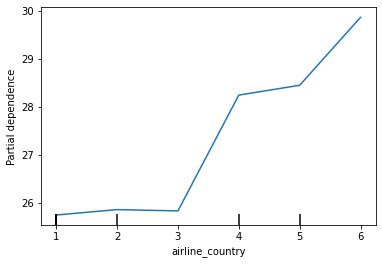

In [20]:
# PDP par sklearn
features_info = {
    # features of interest
    "features": ["airline_country"]}

display = PartialDependenceDisplay.from_estimator(
    model,
    Xtest,
    **features_info,    
)

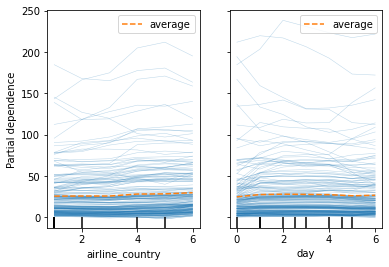

In [21]:
# ICE par sklearn
features_info = {
    # features of interest
    "features": ["airline_country", "day"], "kind": "both","centered": False,}

display = PartialDependenceDisplay.from_estimator(
    model,
    Xtest,
    **features_info,    
)

In [22]:
xpl.plot.contribution_plot(col="airline_country")

In [23]:
xpl.plot.contribution_plot(col="day")

In [24]:
xpl.plot.features_importance()

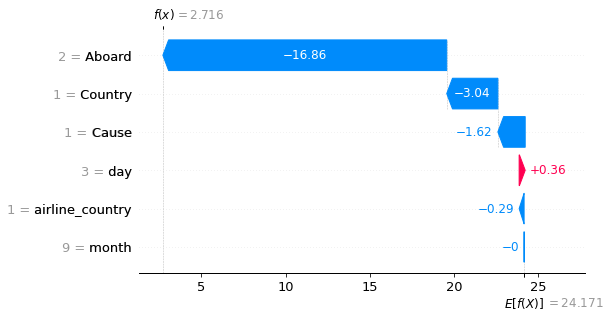

In [25]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

In [26]:
xpl.plot.local_plot(index=0)

In [27]:
model_lgb = lightgbm.LGBMRegressor()
model_lgb.fit(Xtrain, ytrain, verbose=False)

LGBMRegressor()

In [28]:
xpl_lgb = SmartExplainer(model=model_lgb,preprocessing=encoder)

xpl_lgb.compile(
    x=Xtest,    
    y_target = ytest
)

In [29]:
xpl_lgb.plot.interactions_plot('airline_country', 'Country')



In [30]:
xpl_lgb.plot.top_interactions_plot(nb_top_interactions=5)